In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats

import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
session_info = {'date': "01_09_2024",
                'genotype_dir': 'ER4d_sytjGCaMP7f_EPG_jRGECO1a',
                'fly': 'fly1',
                'session': 'open_loop-000',
                'full_genotype': '+/-; R4d-AD, LexOpjRGECO/ R27F02-LexA; R4d-DBD/UASsytjGCaMP7f SS00238',
                'ecl date': '8/26/2023',
                'fictrac_scan_num':0,
                'fictrac_dat_file' : None,
                'notes':''}

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
session_info['fictrac_dir']= f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}"
                            

pp = st2p.preprocessing.ColumnarRingImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_dir = session_info['fictrac_dir'],
                                         fictrac_dat_file = session_info['fictrac_dat_file'],
                                         fictrac_scan_num = session_info['fictrac_scan_num'])

In [3]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=1, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()


Exception ignored in: Traceback (most recent call last):
  File "/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/runpy.py", line 187, in _run_module_as_main
<function _releaseLock at 0x7a61a2ea6200>
Traceback (most recent call last):
  File "/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
Traceback (most recent call last):
  File "/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/runpy.py", line 187, in _run_module_as_main
Traceback (most recent call last):
  File "/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/runpy.py", line 187, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/runpy.py", line 110, in _get_module_details
  File "/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/runpy.py", line 110, in _get_module_details


KeyboardInterrupt: 

In [4]:
# pp.align_fictrac()

In [5]:
nap = pp.open_napari()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [6]:
print('done')

done


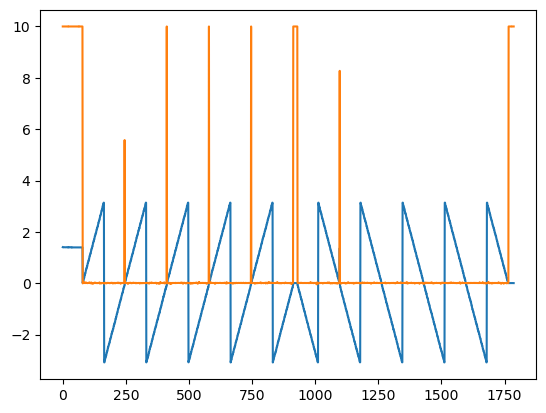

In [7]:

fig, ax = plt.subplots()
# time = pp.fictrac_aligned['Time(ms)']
# inds = slice(0,10000)
# # ax.plot(time[inds], pp.fictrac_aligned['integ heading (lab)'].iloc[inds])
ax.plot(pp.voltage_recording_aligned[' Heading'])
ax.plot(pp.voltage_recording_aligned[' Y/Index'])
# ax.plot(time[inds],mask[inds])

In [8]:
print('')

In [9]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [21]:
y_r4d = pp.calculate_zscored_F('rois_R4d', exp_detrend=True,zscore=False,reg_other_channel=True)
y_epg = pp.calculate_zscored_F('rois_EB', exp_detrend=True,zscore=False, reg_other_channel=True)
# y_r4d = pp.timeseries['rois_R4d']-pp.timeseries['background']
# b = np.percentile(y_r4d[:,:,mask],10,axis=-1,keepdims=True)
# y_r4d = (y_r4d-b)/b
# y_epg = pp.timeseries['rois_EB']-pp.timeseries['background']
# b = np.percentile(y_epg[:,:,mask],10,axis=-1,keepdims=True)
# y_epg = (y_epg-b)/b

# y_r4d = sp.stats.zscore(pp.timeseries['rois_R4d']-pp.timeseries['background'],axis=-1)

# y_epg = sp.stats.zscore(pp.timeseries['rois_EB']-pp.timeseries['background'], axis=-1)


In [29]:
pp.save()

In [3]:
if True:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    y_r4d = pp.timeseries['rois_R4d_z']
    y_epg = pp.timeseries['rois_EB_z']
    n_rois=y_r4d.shape[1]
    

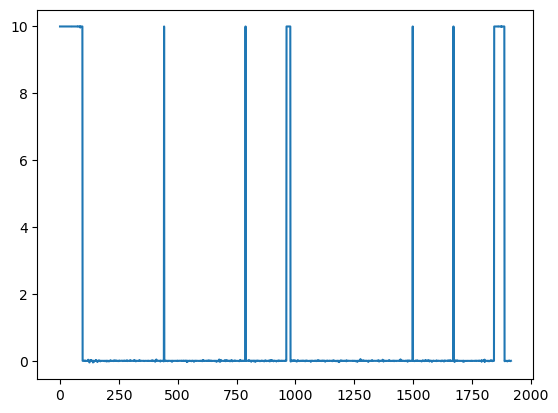

In [12]:
fig,ax = plt.subplots()
ax.plot(pp.voltage_recording_aligned[' Y/Index'])

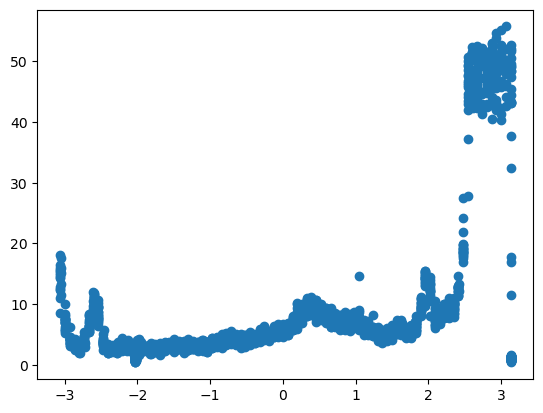

In [13]:
fig, ax = plt.subplots()
heading = np.angle(np.exp(1j*(-1*pp.voltage_recording_aligned[' Heading'].to_numpy()-np.pi)))
heading.shape
pp.timeseries['background'].shape
ax.scatter(heading, pp.timeseries['background'][1,:,:])
mask = (np.abs(heading)<2)&(pp.voltage_recording_aligned[' Y/Index']<2)#&(pp.timeseries['background'][1,:,:]<30)

In [22]:
coef = .0
if coef ==0:
    y_r4d-=1
    y_epg -=1
    y_r4d_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y_r4d, 2, axis=-1),1,axis=1, mode='wrap')
    y_epg_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y_epg, 2, axis=-1),1,axis=1, mode='wrap')
else:        
    y_r4d[1,:,:] -= coef*y_r4d[0,:,:]-coef
    y_epg[0,:,:] -= coef*y_epg[1,:,:] -coef #- y_epg[1,:,:].mean(axis=-1, keepdims=True)
    y_r4d_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y_r4d, 2, axis=-1),1,axis=1, mode='wrap')
    y_epg_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y_epg, 2, axis=-1),1,axis=1, mode='wrap')

    


-0.06361746826479876 0.005341602274347351
[[-14.38287246  -0.08894859]
 [  0.69126907  13.54649544]]


/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


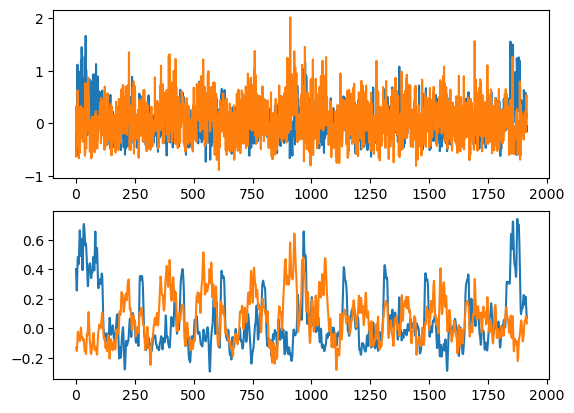

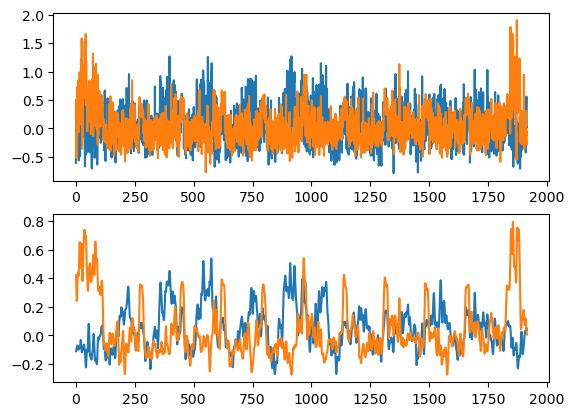

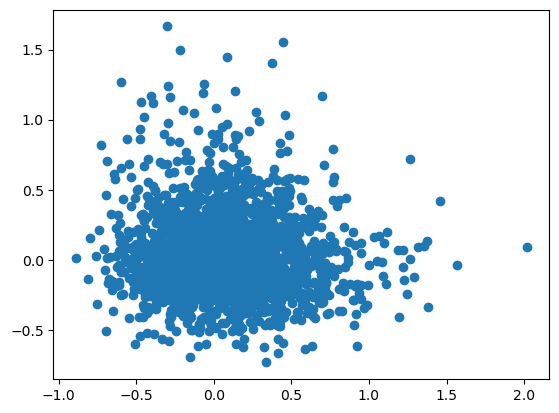

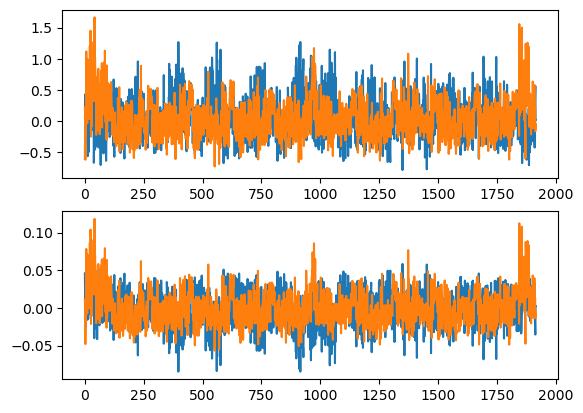

In [23]:
fig, ax = plt.subplots(2,1)
ax[0].plot(y_r4d[1,1,:])
ax[0].plot(y_r4d[0,1,:])
ax[1].plot(y_r4d_sm[1,1,:])
ax[1].plot(y_r4d_sm[0,1,:])

fig, ax = plt.subplots(2,1)
ax[0].plot(y_epg[0,1,:])
ax[0].plot(y_epg[1,1,:])
ax[1].plot(y_epg_sm[0,1,:])
ax[1].plot(y_epg_sm[1,1,:])

fig,ax = plt.subplots()
# ax.plot(y_r4d[0,1,:])
# ax.plot(y_r4d[1,1,:])
ax.scatter(y_r4d[0,1,:], y_r4d[1,1,:])
r,p = sp.stats.pearsonr(y_r4d[0,1,:], y_r4d[1,1,:])
print(r,p)

import sklearn
from sklearn.decomposition import FastICA

X = np.column_stack([y_epg[0,1,:].T, y_r4d[1,1,:].T])
ica = FastICA().fit(X)
Xica = ica.transform(X)
fig, ax = plt.subplots(2,1)
ax[0].plot(X[:,0])
ax[0].plot(X[:,1])
ax[1].plot(Xica[:,0])
ax[1].plot(Xica[:,1])
print(ica.mixing_)


In [24]:
x_f,y_f = st2p.utilities.pol2cart(y_r4d_sm[1,:,:] ,np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
# x_f,y_f = st2p.utilities.pol2cart(y_r4d_sm[1,:,:]-y_r4d_sm[1,:,:].mean(axis=0,keepdims=True) ,np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])

rho_r4d, phi_r4d = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))

x_f,y_f = st2p.utilities.pol2cart(y_epg_sm[0,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
# x_f,y_f = st2p.utilities.pol2cart(y_epg_sm[0,:,:] -y_epg_sm[0,:,:].mean(axis=-1,keepdims=True),np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho_epg, phi_epg = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))

_,offset_r4d = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_r4d-heading))
_,offset_epg = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_epg-heading))

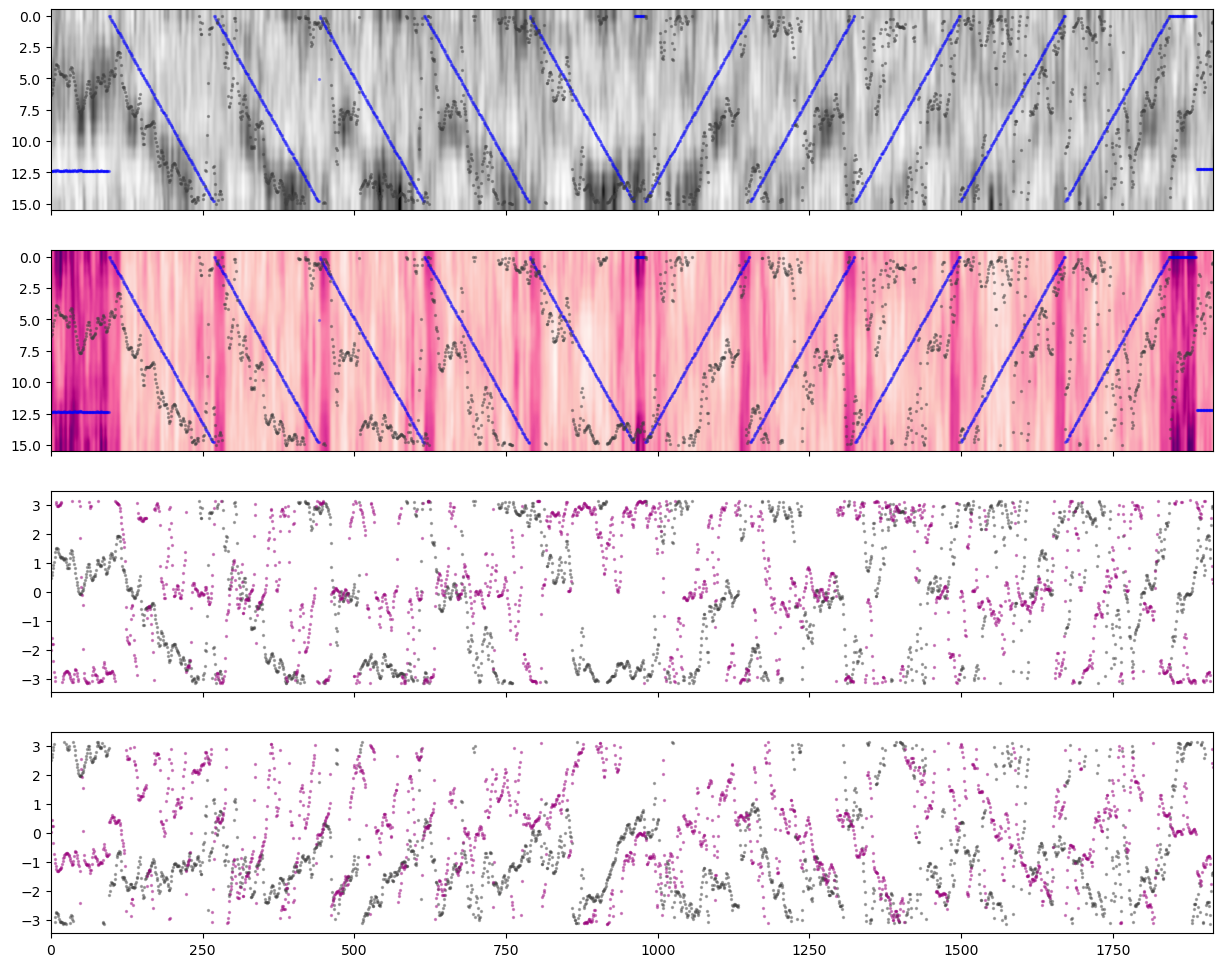

In [25]:
fig, ax= plt.subplots(4,1, figsize=[15,12], sharex=True)
ax[0].imshow(y_epg_sm[0,::-1,:], aspect='auto', cmap= 'Greys')#, vmax=.4, vmin=-.2)
ax[1].imshow(y_r4d_sm[1,::-1,:] , aspect='auto', cmap= 'RdPu')#, vmin=-.2, vmax=.4)


x = np.arange(y_epg.shape[-1])
fill = np.ones_like(y_r4d_sm[1,:,:])
fill[:, mask]=np.nan
# ax[0].imshow(fill, aspect='auto', cmap='gray', vmax=1, vmin=0, alpha=.4)
# ax[1].imshow(fill, aspect='auto', cmap='gray', vmax=1, vmin=0, alpha=.2)
                   

heading_ = 15-15*(heading+np.pi)/2/np.pi
ax[0].scatter(x, heading_, alpha=.3, s=2, color='blue')
ax[0].scatter(x, 15-15*(phi_epg+np.pi)/2/np.pi, color=plt.cm.Greys(.8), alpha = .4, s=2)
ax[1].scatter(x, heading_, alpha=.3, s=2, color='blue')
ax[1].scatter(x, 15-15*(phi_epg+np.pi)/2/np.pi, color=plt.cm.Greys(.8), alpha = .4, s=2)


# print(y.shape, heading.shape)
# ax[2].scatter(x,heading)
ax[2].scatter(x, phi_epg, color=plt.cm.Greys(.8), alpha = .4, s=2)
ax[2].scatter(x, phi_r4d, color=plt.cm.RdPu(.8), alpha = .4, s=2)
ax[3].scatter(x, offset_epg, color=plt.cm.Greys(.8), alpha = .4, s=2)
ax[3].scatter(x, offset_r4d, color=plt.cm.RdPu(.8), alpha = .4, s=2)


0.34753161951695855


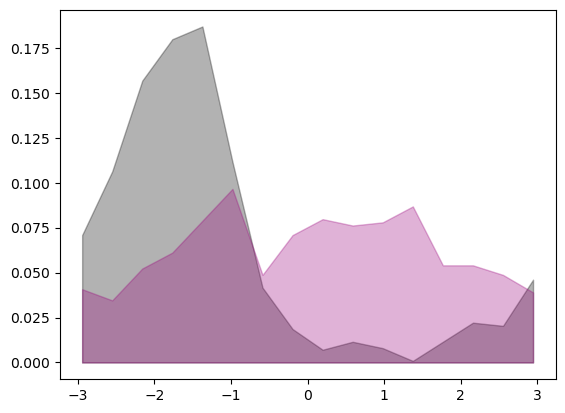

In [26]:
fig, ax= plt.subplots()
bins = np.linspace(-np.pi, np.pi, num=17)
centers = (bins[1:] +bins[:-1])/2



epg_hist,_ = np.histogram(offset_epg[mask], bins)
ax.fill_between(centers, epg_hist/epg_hist.sum(), color='black', alpha=.3)

r4d_hist,_ = np.histogram(offset_r4d[mask], bins)
ax.fill_between(centers, r4d_hist/r4d_hist.sum(), color=plt.cm.RdPu(.8), alpha=.3)

print(sp.stats.circvar(offset_epg[mask]))

(2, 16, 1916)


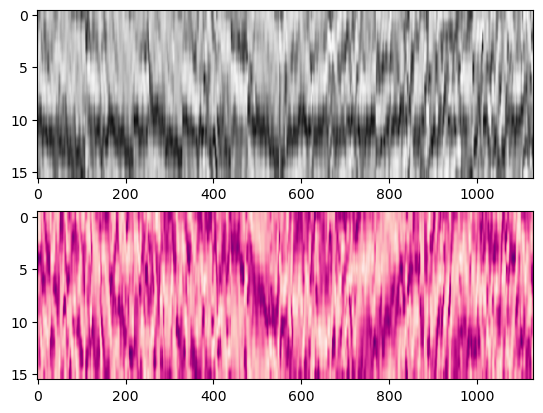

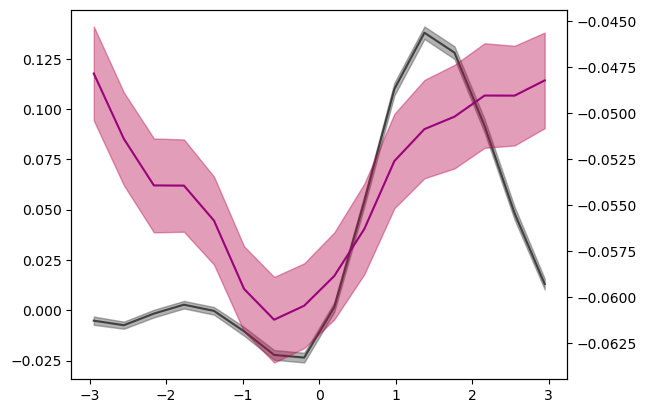

In [27]:
heading_bins = np.linspace(-np.pi, np.pi, num=17)
heading_dig = np.digitize(heading, heading_bins)-1

y_h_aligned = np.zeros_like(y_epg_sm)
for ind in range(heading.shape[0]):
    y_h_aligned[0,:,ind] = np.roll(y_epg_sm[0,:,ind], -heading_dig[ind])
    y_h_aligned[1,:,ind] = np.roll(y_r4d_sm[1,:,ind], -heading_dig[ind])
y_h_aligned_z = sp.stats.zscore(y_h_aligned, axis=1)
print(y_h_aligned_z.shape)

fig, ax = plt.subplots(2,1)
ax[0].imshow(y_h_aligned_z[0,:,:][:,mask],aspect='auto',cmap='Greys')
ax[1].imshow(y_h_aligned_z[1,:,:][:,mask],aspect='auto',cmap='RdPu')



fig, ax= plt.subplots()
ha_avg_epg = y_h_aligned[0,:,:][:,mask].mean(axis=-1)
ha_sem_epg = sp.stats.sem(y_h_aligned[0,:,:][:,mask],axis=-1)
ax.plot(centers, ha_avg_epg, color=plt.cm.Greys(.8))
ax.fill_between(centers, ha_avg_epg - ha_sem_epg, ha_avg_epg + ha_sem_epg, color= plt.cm.Greys(.8), alpha=.4)

ha_avg_r4d = y_h_aligned[1,:,:][:,mask].mean(axis=-1)
ha_sem_r4d = sp.stats.sem(y_h_aligned[1,:,:][:,mask],axis=-1)
axx = ax.twinx()
axx.plot(centers, ha_avg_r4d, color=plt.cm.RdPu(.8))
axx.fill_between(centers, ha_avg_r4d - ha_sem_r4d, ha_avg_r4d + ha_sem_r4d, color= plt.cm.PuRd(.8), alpha=.4)


# ax.set_ylim([-1.3,1.3])

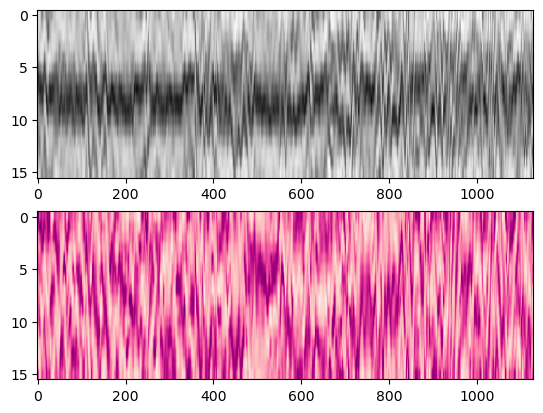

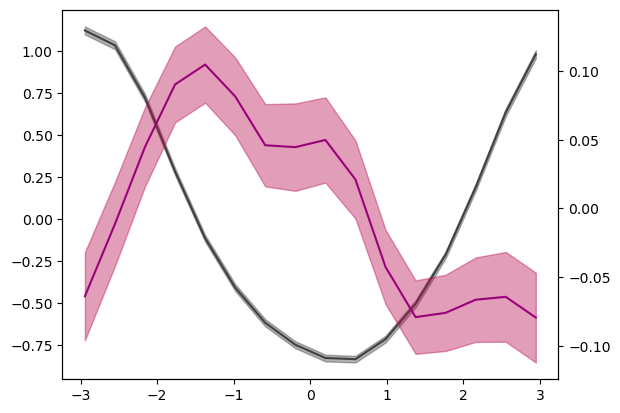

In [28]:

epg_dig = np.digitize(phi_epg, heading_bins)-1

y_epg_aligned = np.zeros_like(y_epg_sm)
for ind in range(heading.shape[0]):
    y_epg_aligned[0,:,ind] = np.roll(y_epg_sm[0,:,ind], -epg_dig[ind])
    y_epg_aligned[1,:,ind] = np.roll(y_r4d_sm[1,:,ind], -epg_dig[ind])
y_epg_aligned_z = sp.stats.zscore(y_epg_aligned, axis=1)

fig, ax = plt.subplots(2,1)
ax[0].imshow(np.roll(y_epg_aligned_z[0,:,:][:,mask],8, axis=0),aspect='auto',cmap='Greys')
ax[1].imshow(np.roll(y_epg_aligned_z[1,:,:][:,mask],8, axis=0),aspect='auto',cmap='RdPu')

fig, ax= plt.subplots()
ea_avg_epg = y_epg_aligned_z[0,:,:][:,mask].mean(axis=-1)
ea_sem_epg = sp.stats.sem(y_epg_aligned_z[0,:,:][:,mask],axis=-1)
ax.plot(centers, ea_avg_epg, color=plt.cm.Greys(.8))
ax.fill_between(centers, ea_avg_epg - ea_sem_epg, ea_avg_epg + ea_sem_epg, color= plt.cm.Greys(.8), alpha=.4)

ea_avg_r4d = y_epg_aligned_z[1,:,:][:,mask].mean(axis=-1)
ea_sem_r4d = sp.stats.sem(y_epg_aligned_z[1,:,:][:,mask],axis=-1)
axx = ax.twinx()
axx.plot(centers, ea_avg_r4d, color=plt.cm.RdPu(.8))
axx.fill_between(centers, ea_avg_r4d - ea_sem_r4d, ea_avg_r4d + ea_sem_r4d, color= plt.cm.PuRd(.8), alpha=.4)


# ax.set_ylim([-1.3,1.3])